# Computer Vision SotA



В прошлом семестре мы разбирали свертки и даже упоминали библиотеку `timm`, содержащую много CV моделей.

В репозитории этой библиотеки хранятся результаты бенчмарков. Давайте посмотрим на них.

In [ ]:
import numpy as np
import pandas as pd
import altair as alt
from vega_datasets import data

Отдельно подсветим эффективные по Парето модели: модели, для которых не существует других моделей, которые были бы одновременно меньше и точнее.

In [ ]:
def is_pareto_efficient(costs, return_mask = True):
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient

In [ ]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/huggingface/pytorch-image-models/main/results/results-imagenetv2-matched-frequency.csv"
)
data.top1 = data.top1.astype(float)
data.param_count = data.param_count.str.replace(",", "").astype(float)
data["neg_top1"] = -data.top1
data["pareto_optimal"] = is_pareto_efficient(data[["neg_top1", "param_count"]].values)

alt.Chart(data).mark_circle().encode(
    x="param_count:Q", y="top1:Q", tooltip=["model", "top1", "top5"], color="pareto_optimal"
).interactive().properties(
    width=800,
    height=800
)


alt.Chart(...)

Что можно вынести из этих данных:

1. Среди маленьких моделей (<40 млн параметров) есть наши старые знакомые *CNN*: EfficientNet, ConvNext
2. В топе по точности -- большие сети, основанные на трансформерах. Это EVA, MaxViT.

Сегодня разберем, что же позволяет этим моделям достигать такой точности.


## Visual Transfomer Architecture

Начнем с архитектуры. Она очень проста.
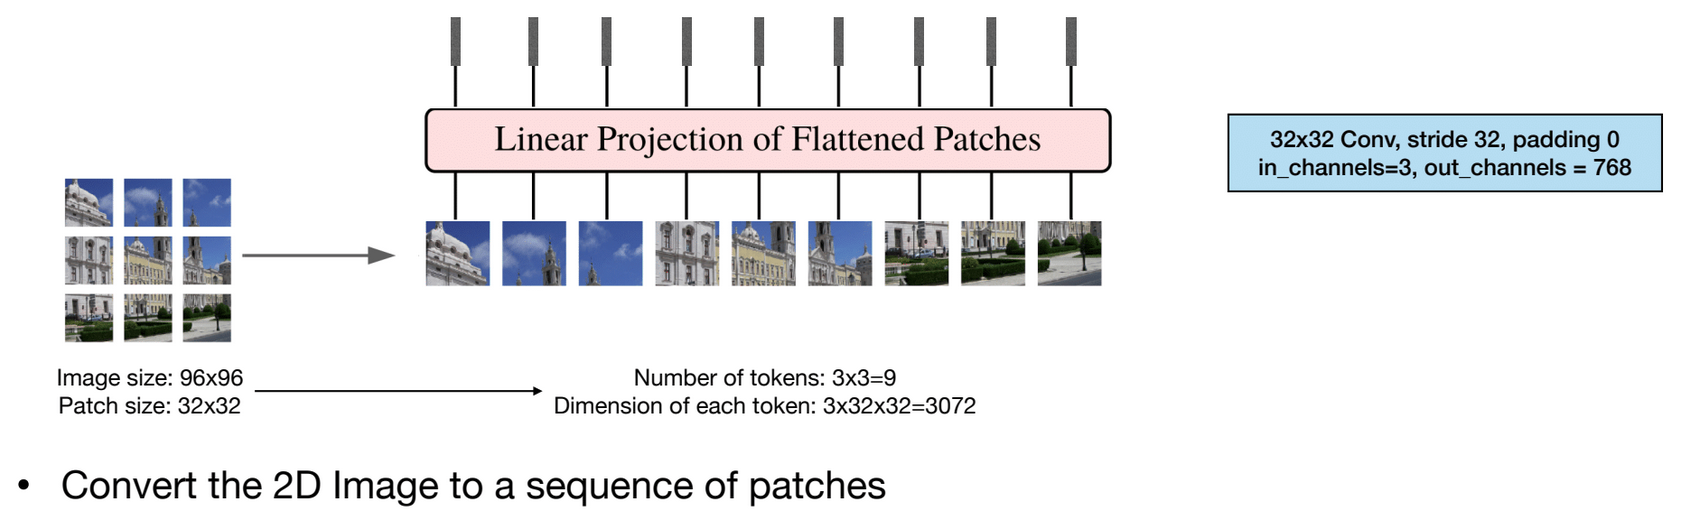


На первом шаге нам нужно разбить изображение на сегменты (patches). У сегмента должен быть фиксированный размер.

Каждый сегмент переводят в вектор и домножают на матрицу.

Затем к полученным векторам добавляют обучаем позиционный эмбеддинг.

Обычно кроме векторов патчей добавляют аналог токена `[CLS]`. В нем будет собираться информация уровня всего изображения, которую будем использовать для классификации.

После того, как векторы пройдут через обычный transformer encoder, вектор, соответствующий токену `[CLS]` попадает в полносвязную сеть, которая и предсказывает нужные нам значения (например, вероятности принадлежности картинки к какокму-то классу).

Все это в сборе выглядит так:

<img src='https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/vit_input.png?raw=true'>

Эта архитектура называется *ViT*.

Сразу видна основная проблема модели: векторы патчей сильно меняются даже при малейшем изменении картинки, например сдвиге.

При этом у модели нет проблемы *рецептивного поля* как у CNN.

Можно ли скрестить CNN и Attention, взяв лучшее от двух архитектур? Конечно, можно. Так работают многие модели из списка `timm`, мы разберем одну из лучших архитектур - **MaxViT**

### MaxViT

Архитектура MaxViT представляет собой масштабируемую и эффективную модель, известную как мультиосевое внимание, которая сочетает в себе локальное и глобальное внимание. Этот дизайн позволяет осуществлять глобально-локальные пространственные взаимодействия с (псевдо)-линейной вычислительной сложностью.


Общая архитектура выглядит так:

<img src='https://github.com/google-research/maxvit/raw/main/doc/maxvit_arch.png'>

Здесь можно увидеть свертки. Они позволяют немного снизить проблему с небольшимим изменениями изображений.

Еще это позволяет смягчить проблему с квадратичной сложностью (по памяти и вычислениям) attention.

Еще большей оптимизации позволяют достичь особые SA блоки. Это не классический Multi-head Self Attention, он устроен хитрее.



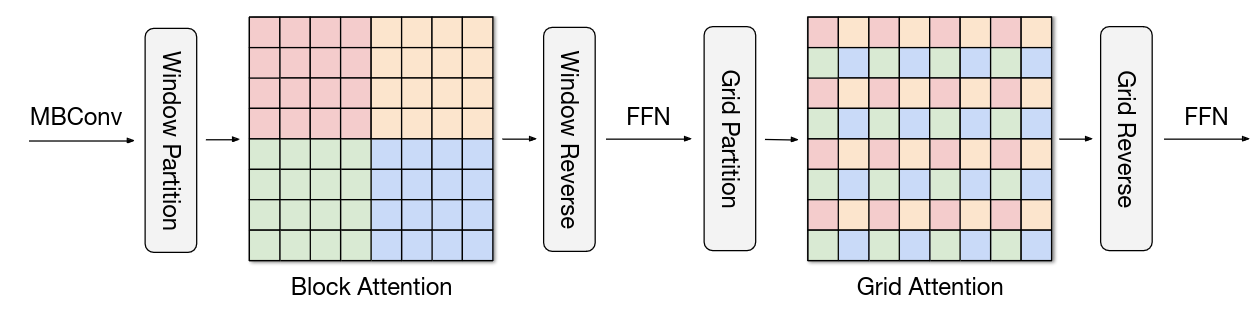

*Block-SA* -- локальный attention. Для каждого блока в изображении (отмечены разными цветами) Self-Attention считается отдельно. Можно посчитать, насколько это выгодно.

*Grid-SA* тоже разбивет все патчи картины на отдельные блоки, но они *разрежены* (*dilated*). Это позволяет эффективно собирать информацию со всего изображения в любом патче.

Такую модель можно обучать куда эффективнее, и в итоге получаются одни из самых лучших моделей на сегодня.

Но не только архитектурой достигаются хорошие результаты. Поговорим о данных.

# Self-supervision в CV и не только

На протяжении последнего десятилетия одним из главных рецептов успеха для различных задач Компьютерного Зрения было получение визуальных представлений с помощью обучения с учителем для ImageNet классификации. Затем эти представления или веса модели использовали для инициализации других задач Компьютерного Зрения для которых существует нехватка тренировочных данных.

Однако получение аннотаций для набора данных масштаба ImageNet занимает очень много времени и это достаточно дорого. К примеру: для разметки 14 миллионов изображений из ImageNet потребовалось примерно 22 человеко-года.

Поэтому сообщество начало искать альтернативные способы разметки, такие как хэштеги для изображений в социальных сетях, GPS локации или подходы самостоятельного обучения, когда метка является свойством самой выборки данных.

Подход *self-supervised learning* состоит в использовании автоматически получаемых меток для некоторого набора данных. С примерами SSL мы уже сталкивались:
1. Предсказание пропущенных слов (токенов) в Masked Language Models (BERT).
2. Предсказание следующего слова в Causal Language Models (GPT).

Но сегодня поговорим об изображениях. В них есть два основных подхода:

1. *Contrastive Learning*
2. *Non-contrastive Methods*

Сможете сразу догадаться, в чем их суть?

## Contrastive Learning на примере SimCLR

Тут все очень просто:

Одни картинки после аугментаций должны оставаться похожими, а разные -- разными.

<img src ="https://1.bp.blogspot.com/--vH4PKpE9Yo/Xo4a2BYervI/AAAAAAAAFpM/vaFDwPXOyAokAC8Xh852DzOgEs22NhbXwCLcBGAsYHQ/s640/image4.gif" width="800">


Для метода необходим большой набор негативных примеров. Это значительно замедляет обучение.

Контрастивные методы также очень чувствительны к структуре датасета. Часто они "идут по легкому пути", выхватывая бесполезную информацию из объектов.

Так, для картинок SimCLR очень часто обращает внимание только на распределение цветов, не определяя ничего семантического на изображении.Из-за этого надо очень внимательно подходить к выбору аугментаций на рисунках.

## Non-contrastive methods. Bootrstrap Your Own Latent (BYOL)

BYOL избавляется от негативной выборки SimCLR. Важно не то, насколько разные получатся репрезентации для разных объектов, а то, насколько близкие получатся репрезентации одних и тех же.

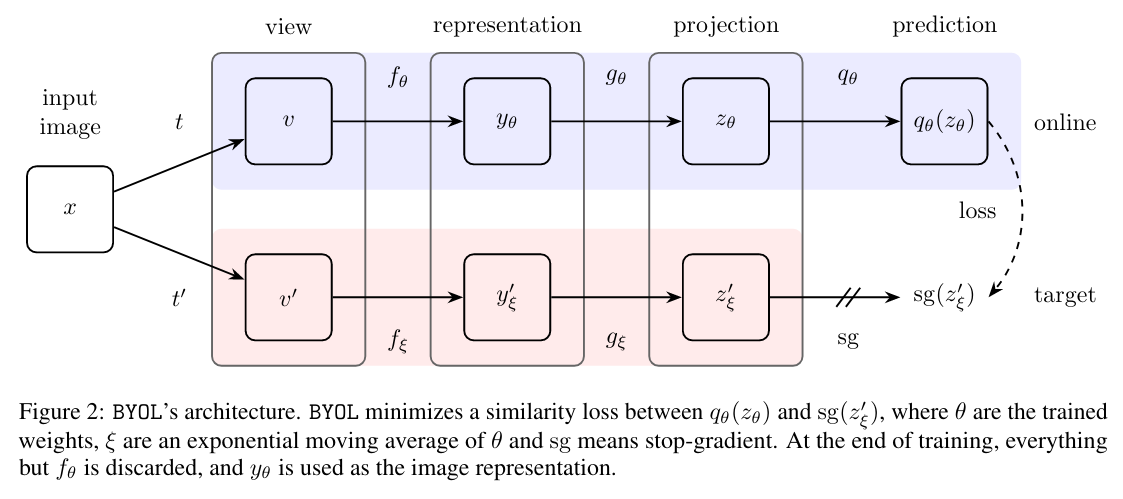


В методе используются две сети:

- Учитель
- Студент

Обеим сетям на вход подаются объекты, полученные модификацией одного исходного примера. Это могут быть:
1. Два предложения из одного текста
2. Два куска одного изображения

То есть, нам нужен процесс, порождающий пары объектов, которые мы будем считать похожими.

Учитель не обучается, он просто производит репрезентацию объекта, а целью студента является приблизиться к этой репрезентации.

Хитрость в том, что веса учителя обновляются каждую эпоху с помощью весов студента:

$$\theta^{i+1}_{teacher} = (1-\epsilon)\theta^{i}_{teacher} + ϵ\theta^{i}_{student}$$

Тонкость в том, чтобы подобрать удачный $ϵ$. Слишком большой будет приводить к тривиальным решениям (учитель станет слишком похож на ученика). Слишком маленький приведет к долгому обучению, а может даже вообще привести к невозможности обучения.

### DINO

DINO по сути своей является BYOL.

И нейросеть, которая была обучена таким образом сегментировать изображения без обучения с учителем - [DINO](https://ai.facebook.com/blog/dino-paws-computer-vision-with-self-supervised-transformers-and-10x-more-efficient-training/).

Подход - модификация BYOL. Теперь учителя и ученику даются еще и разные по природе аугментации.

Учитель видит только большие, захватывающие большую часть изображения, а студент - и большие, и маленькие.

При этом даже на маленькой части изображения он должен выдавать эмбединг похожий на эмбединг учителя на большой части.

Фактически - нейросеть учится по уху кота определять, что на картинке таки есть кот

In [ ]:
!git clone https://github.com/facebookresearch/dino

Cloning into 'dino'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 175 (delta 57), reused 55 (delta 54), pack-reused 106
Receiving objects: 100% (175/175), 24.44 MiB | 29.31 MiB/s, done.
Resolving deltas: 100% (109/109), done.


In [ ]:
!python dino/visualize_attention.py

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall8_300ep_pretrain.pth
100% 82.7M/82.7M [00:00<00:00, 187MB/s]
Please use the `--image_path` argument to indicate the path of the image you wish to visualize.
Since no image path have been provided, we take the first image in our paper.
./attn-head0.png saved.
./attn-head1.png saved.
./attn-head2.png saved.
./attn-head3.png saved.
./attn-head4.png saved.
./attn-head5.png saved.


In [ ]:
from IPython.display import Image


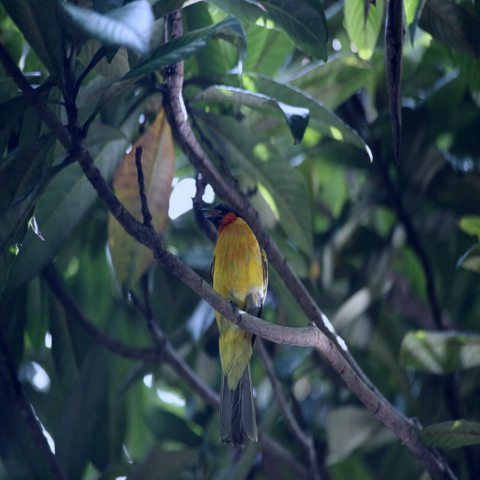

In [ ]:
Image(filename=f"./img.png" )

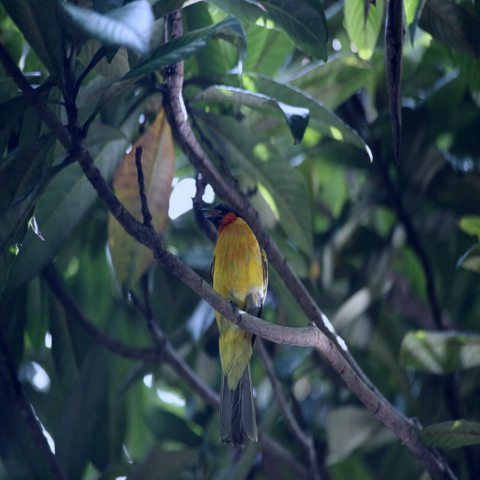

In [ ]:
Image(filename=f"./img.png" )

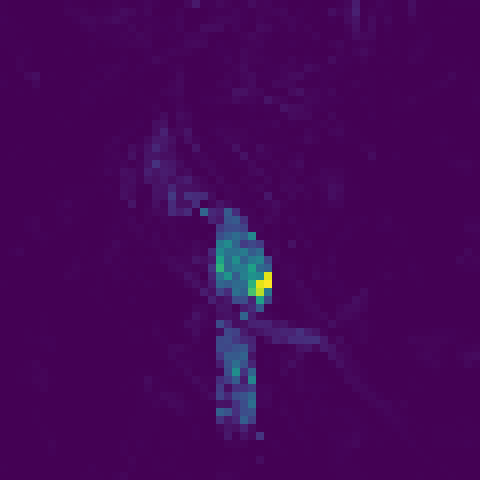

In [ ]:
Image(filename=f"./attn-head1.png")



Видим, что действительно исходное изображение сегментируется.

Можем использовать нейросеть чтобы натренировать лучшие распознаватели птиц/растений и т.д.

А что если подать на вход медицинское изображение, похожего на которое вообще не было в датасете?


In [ ]:
!wget https://kodomo.fbb.msu.ru/FBB/year_20/ml/lung.jpeg

--2024-02-21 15:38:20--  https://kodomo.fbb.msu.ru/FBB/year_20/ml/lung.jpeg
Resolving kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)... 93.180.63.127
Connecting to kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)|93.180.63.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116816 (114K) [image/jpeg]
Saving to: ‘lung.jpeg’

lung.jpeg           100%[===================>] 114.08K   279KB/s    in 0.4s    

2024-02-21 15:38:21 (279 KB/s) - ‘lung.jpeg’ saved [116816/116816]



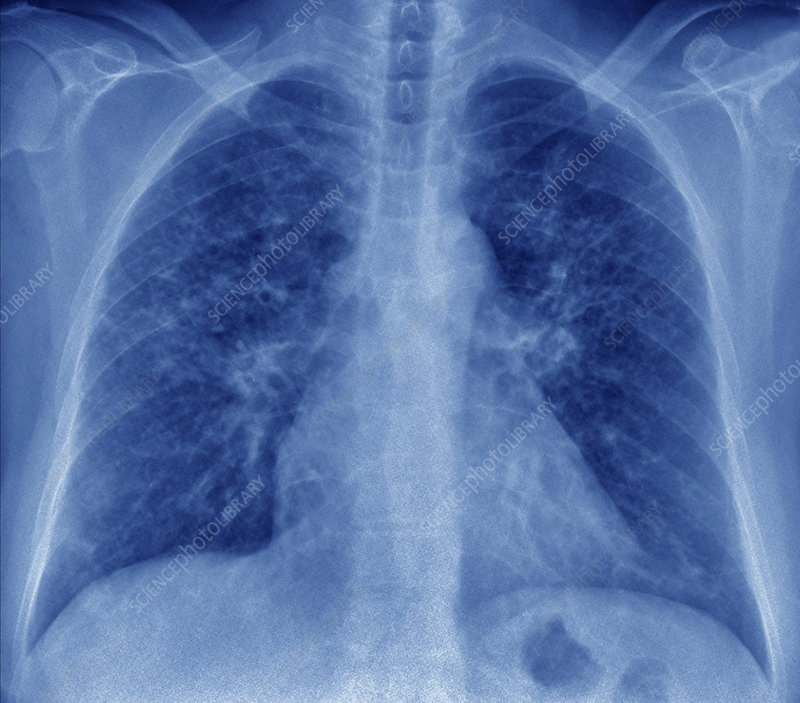

In [ ]:
Image(filename="lung.jpeg")

In [ ]:
!python dino/visualize_attention.py --image_path lung.jpeg

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
./attn-head0.png saved.
./attn-head1.png saved.
./attn-head2.png saved.
./attn-head3.png saved.
./attn-head4.png saved.
./attn-head5.png saved.


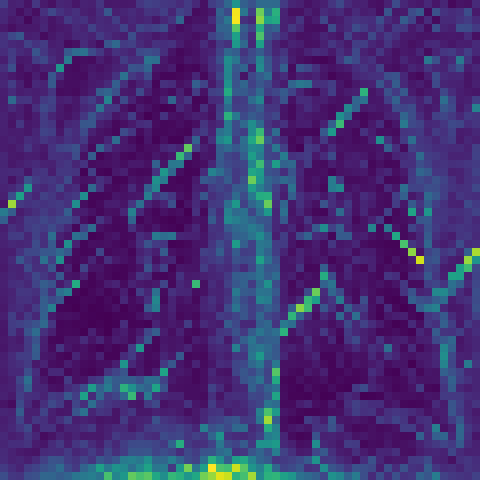

In [ ]:
Image(filename=f"./attn-head1.png")

Внезапно, сегментация вполне сносная. Но на смену DINO пришел SAM, который сегментирует действительно любые изображения.

# Примеры работы на биологических данных. Сегментация на MaxViT

MaxViT нашел свое применение в [сегментации медицинских изображений](https://arxiv.org/abs/2305.08396).



<img src ="https://github.com/PRLAB21/MaxViT-UNet/raw/main/resources/maxvit_unet_02.png" width="800">


Узнаете архитектуру сегментатора?

Для "разжатия" изображения здесь используется те же транспонированные свертки.

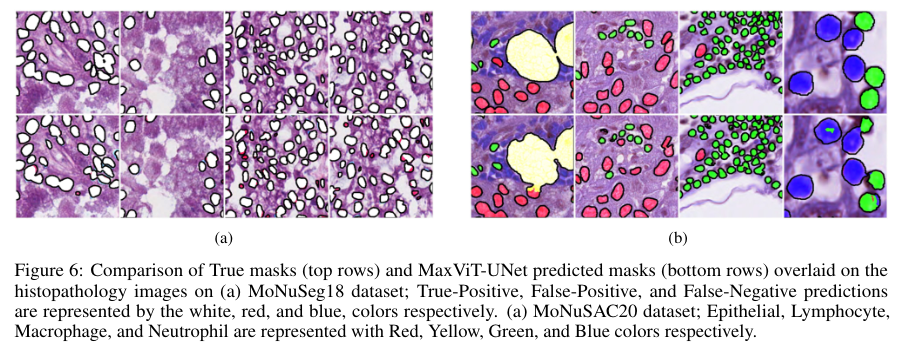

В статье и ее репозитории можно посмотреть на то, как работают с гистологическими изображениями в DL.